In [1]:
import os
import nibabel as nib
from pathlib import Path
import re

def identify_t1_scans(base_dir: str) -> dict:
    """Identify T1 scans from PAR/REC files in the given directory.
    
    Args:
        base_dir: Base directory containing scan folders
        
    Returns:
        Dictionary mapping subject folders to their T1 scan paths
    """
    t1_scans = {}
    
    # Common T1 sequence identifiers
    t1_identifiers = [
        r'T1TFE',  # T1 Turbo Field Echo
        r'T1',
        r'T1W',
        r'T1-weighted',
        r'T1_weighted',
        r'T1W_',
        r'T1_',
        r'T1W-',
        r'T1-',
        r'T1W ',
        r'T1 ',
        r'T1TSE',  # T1 Turbo Spin Echo
        r'T1FFE',  # T1 Fast Field Echo
        r'T1GRE',  # T1 Gradient Echo
        r'T1MPRAGE'  # T1 MPRAGE
    ]
    
    # Walk through all subdirectories
    for root, dirs, files in os.walk(base_dir):
        # Look for PAR files
        par_files = [f for f in files if f.endswith('.PAR')]
        
        if par_files:
            print(f"\nFound PAR files in: {root}")
            for par_file in par_files:
                par_path = os.path.join(root, par_file)
                
                # Read PAR file header
                try:
                    # Load PAR/REC file using nibabel
                    par_img = nib.load(par_path)
                    header = par_img.header
                    
                    # Get scan parameters from header
                    scan_type = str(header.general_info.get("tech", ""))
                    protocol = str(header.general_info.get("protocol_name", ""))
                    scan_mode = str(header.general_info.get("scan_mode", ""))
                    
                    # Print header information
                    # print(f"\nHeader info for {par_file}:")
                    # print(f"Scan type: {scan_type}")
                    # print(f"Protocol: {protocol}")
                    # print(f"Scan mode: {scan_mode}")
                    
                    # Check if it's a T1 scan
                    is_t1 = False
                    
                    # Check scan type name
                    for identifier in t1_identifiers:
                        if re.search(identifier, scan_type, re.IGNORECASE) or \
                           re.search(identifier, protocol, re.IGNORECASE):
                            is_t1 = True
                            break
                    
                    if is_t1:
                        # print(f"Found T1 scan: {par_file}")
                        # print(f"Scan type: {scan_type}")
                        # print(f"Protocol: {protocol}")
                        # print(f"Scan mode: {scan_mode}")
                        
                        # Store the path
                        subject_name = os.path.basename(root)
                        t1_scans[subject_name] = par_path
                        print(subject_name)
                    
                except Exception as e:
                        pass
    
    return t1_scans

In [2]:
input_dir = "../../datasets/Craig_scans/"
# Identify T1 scans
print("Identifying T1 scans...")
t1_scans = identify_t1_scans(input_dir)

print(t1_scans)

Identifying T1 scans...

Found PAR files in: ../../datasets/Craig_scans/20130801
20130801

Found PAR files in: ../../datasets/Craig_scans/20100513
20100513

Found PAR files in: ../../datasets/Craig_scans/20100304
20100304

Found PAR files in: ../../datasets/Craig_scans/20130703
20130703

Found PAR files in: ../../datasets/Craig_scans/20100407
20100407

Found PAR files in: ../../datasets/Craig_scans/20100204
20100204
{'20130801': '../../datasets/Craig_scans/20130801/HumanStabiltiy_130801_4_1.PAR', '20100513': '../../datasets/Craig_scans/20100513/20100513-human-stability_3_1.PAR', '20100304': '../../datasets/Craig_scans/20100304/20100304-human-stability_4_1.PAR', '20130703': '../../datasets/Craig_scans/20130703/HumanStability20130703_4_1.PAR', '20100407': '../../datasets/Craig_scans/20100407/20100407-human-stability_3_1.PAR', '20100204': '../../datasets/Craig_scans/20100204/20100204-human-stability_3_1.PAR'}


(256, 256, 120)
(256, 256, 120)
(256, 256, 120)
(256, 256, 120)
(256, 256, 120)
(256, 256, 120)


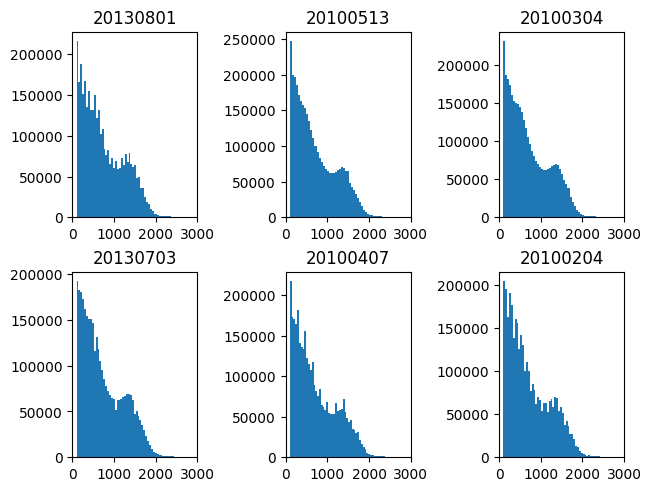

In [31]:
# draw histogram of the t1_scans before the harmonization
import matplotlib.pyplot as plt
num_bins = 200

filter_threshold = 100
fig, axs = plt.subplots(2, 3, constrained_layout=True)
cnt = 0 
for scan_path, par_file in t1_scans.items():
    img = nib.load(par_file)
    data = img.get_fdata()
    print(data.shape)

    # Filter values greater than 100
    filtered_data= data[data > filter_threshold].flatten()
    # print(f"Shape: {data.shape}, Values > {filter_threshold}: {len(filtered_data)}")

    axs[cnt//3, cnt%3].hist(filtered_data, bins=num_bins)
    axs[cnt//3, cnt%3].set_title(scan_path)
    # axs[cnt//3, cnt%3].set_xlabel('Signal Intensity')
    # axs[cnt//3, cnt%3].set_ylabel('Frequency')
    axs[cnt//3, cnt%3].set_xlim(0, 3000)
    cnt += 1

plt.show()

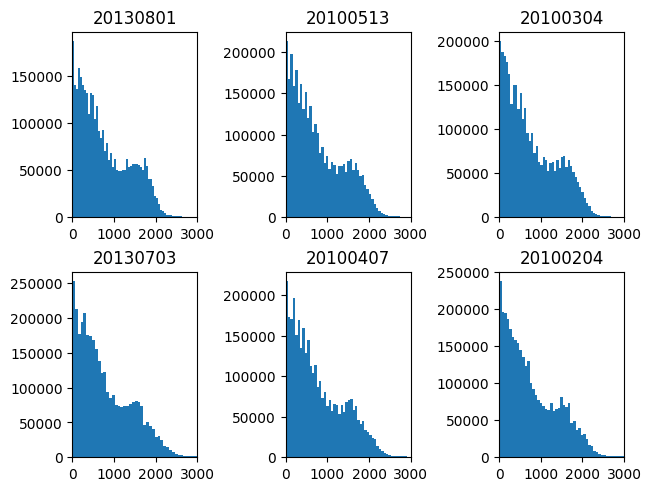

In [36]:
from intensity_normalization.normalize.nyul import NyulNormalize
import numpy as np
# t1_images = [nib.load(par_file).get_fdata() for par_file in t1_scans.values()]
# filtered_images = [data[data > filter_threshold] for data in t1_images]
filtered_images = []
scan_paths = []
for scan_path, par_file in t1_scans.items():
    img_data = nib.load(par_file).get_fdata()
    filtered_data = img_data.copy()
    filtered_data = filtered_data[filtered_data >= filter_threshold]
    filtered_images.append(filtered_data)
    scan_paths.append(scan_path)


# print(len(filtered_images))
normalizer = NyulNormalize(min_percentile=1, max_percentile=99.99, 
                           output_min_value=0, output_max_value=6000)
normalizer.fit(filtered_images)

normalized_images = []
for image in filtered_images:
    normalized_image = normalizer(image)
    # values_below_threshold = np.sum(image < filter_threshold)
    # print(f"Values below threshold for the filtered image: {values_below_threshold}")
    normalized_images.append(normalized_image)
    # values_below_threshold = np.sum(normalized_image < filter_threshold)
    # print(f"Values below threshold for the normalized image: {values_below_threshold}")


# draw histogram of the normalized images
fig, axs = plt.subplots(2, 3, constrained_layout=True)
cnt = 0 
for idx, normalized_image in enumerate(normalized_images):
    axs[cnt//3, cnt%3].hist(normalized_image.flatten(), bins=num_bins)
    axs[cnt//3, cnt%3].set_title(scan_paths[idx])
    axs[cnt//3, cnt%3].set_xlim(0, 3000)
    cnt += 1
plt.show()

